In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import division, print_function
from glob import glob
from scipy.misc import imread
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os

import sys; sys.path.append('..')
from deepcalcium.utils.neurons import mask_outlines
from deepcalcium.models.neurons.unet_2d_summary import UNet2DSummary
from deepcalcium.models.spikes.unet_1d_segmentation import UNet1DSegmentation
from deepcalcium.datasets.nf import nf_load_hdf5
from deepcalcium.utils.spikes import plot_traces_spikes
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

print('Done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


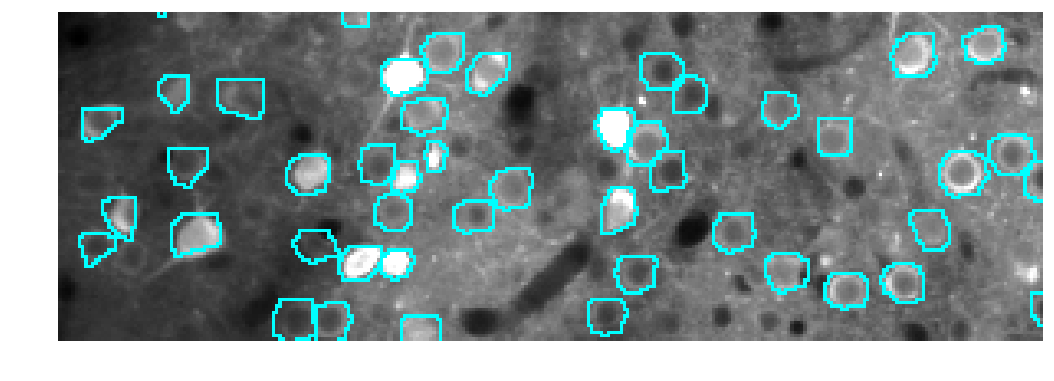

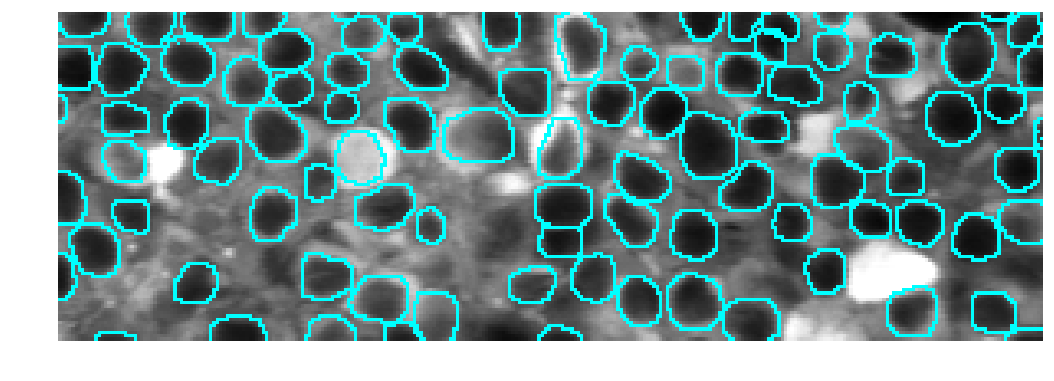

In [3]:
# 2 zoomed figures of several neurons with true outlines.
dsnames = ['neurofinder.02.00', 'neurofinder.03.00']
dspaths = nf_load_hdf5(dsnames)
for n,p in enumerate(dspaths):
    fp = h5py.File(p)
    i = fp.get('series/mean')[200:300, 50:350].astype(np.float32)
    m = fp.get('masks/raw')[:,200:300, 50:350].astype(np.float32)
    o = mask_outlines(i, m, ['cyan'] * len(m))
    fp.close()
    
    plt.figure(figsize=(18,7), frameon=False)
    plt.imshow(o)
    plt.axis('off')
    p = 'suli_fig_neurons_outlined_%02d.png' % n
    plt.savefig(p, dpi=250, bbox_inches='tight', pad_inches=0)
    
    plt.imshow(imread(p))
    plt.show()

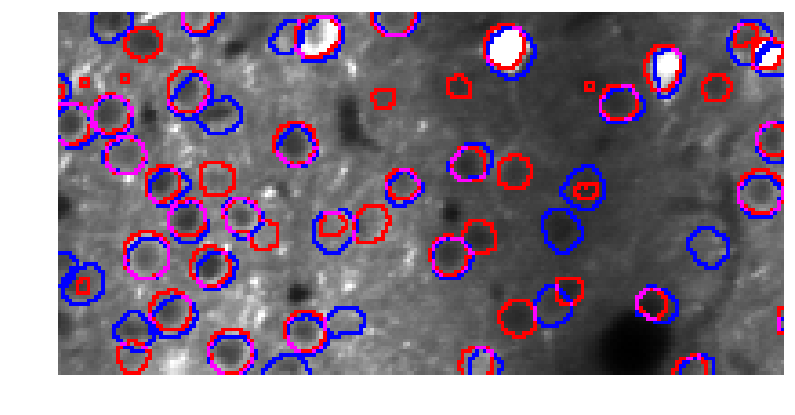

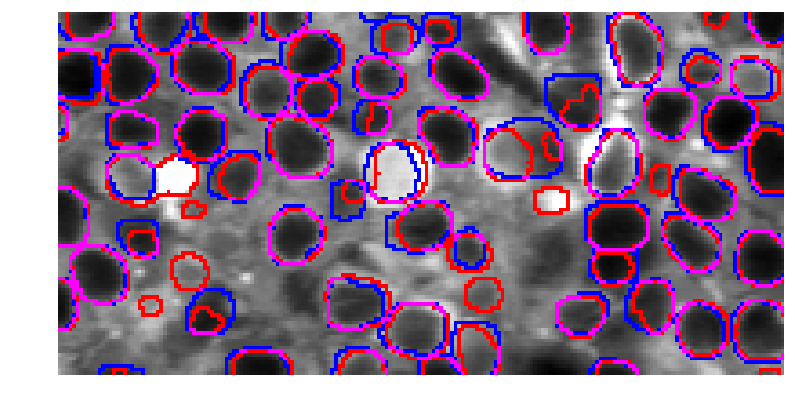

In [10]:
# 4 zoomed figures of several neurons with true and predicted outlines.
dsnames = ['neurofinder.00.01', 'neurofinder.03.00']
dspaths = nf_load_hdf5(dsnames)
# dspaths += ['../data/stjude/sj.neurons.111216.hdf5',
#             '../data/stjude/sj.neurons.010617.hdf5']

model = UNet2DSummary()
mpath = '../checkpoints/neurons_unet2ds_nf/unet2ds_model.hdf5'
preds,_ = model.predict(dspaths, model_path=mpath)
x0,x1,y0,y1 = 200, 300, 50, 250

for n,p in enumerate(dspaths):
    fp = h5py.File(p)
    i = fp.get('series/mean')[x0:x1,y0:y1]
    mt = fp.get('masks/raw')[:,x0:x1,y0:y1]
    mp = preds[n][x0:x1,y0:y1].round()
    o = mask_outlines(i, np.concatenate((mt, mp[np.newaxis])), ['blue'] * len(mt) + ['red'])
    fp.close()
    
    plt.figure(figsize=(18,7), frameon=False)
    plt.imshow(o)
    plt.axis('off')
    p = 'suli_fig_neurons_outlined_pred_%02d.png' % n
    plt.savefig(p, dpi=250, bbox_inches='tight', pad_inches=0)
    
    plt.imshow(imread(p))
    plt.show()

In [4]:
# How many total calcium traces?
nt, ns = 0., 0.
for dataset_path in sorted(glob('../data/stjude/sj.spikes*hdf5')):
    fp = h5py.File(dataset_path)
    nt += fp.get('traces').shape[0]
    ns += np.sum(fp.get('spikes')[...])
    fp.close()
print(nt * 0.8, ns * 0.8)

506.4 5563.2


/raid/alex-scratch/pyenvs/deep-calcium/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


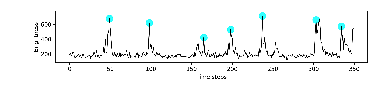

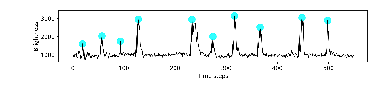

In [19]:
# 2 zoomed figures of a spike train with spikes circled.
dspaths = ['../data/spikes_sj/sj.spikes.010517.hdf5', '../data/spikes_sj/sj.spikes.010617.hdf5']

fp = h5py.File(dspaths[1])
t = fp.get('traces')[9:10,2850:3200]
s = fp.get('spikes')[9:10,2850:3200]
p = 'suli_fig_spikes_00.png'
plot_traces_spikes(t, s, fig_width=10, dpi=350, save_path=p, legend=False)

plt.imshow(imread(p))
plt.axis('off')
plt.show()

fp = h5py.File(dspaths[1])
t = fp.get('traces')[11:12,2450:3000]
s = fp.get('spikes')[11:12,2450:3000]
p = 'suli_fig_spikes_01.png'
plot_traces_spikes(t, s, fig_width=10, dpi=350, save_path=p, legend=False)

plt.imshow(imread(p))
plt.axis('off')
plt.show()

CPU times: user 15 s, sys: 0 ns, total: 15 s
Wall time: 14.5 s


/raid/alex-scratch/pyenvs/deep-calcium/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


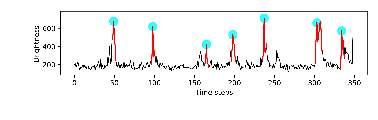

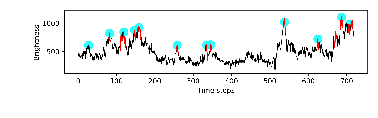

In [27]:
# 2 zoomed figures of a spike train with spikes and predicted spikes marked.
# Unfortunately there's no guarantee as to whether these samples were in 
# training or validation.
dataset_paths = ['../data/spikes_sj/sj.spikes.010517.hdf5', '../data/spikes_sj/sj.spikes.010617.hdf5']

model_path = '../checkpoints/spikes_unet1d_sj/1502452405_model_val_F2_0.813359_096.hdf5'
model = UNet1DSegmentation()
%time spikes_pred_all, names = model.predict(dataset_paths, model_path=model_path)

spikes_pred = spikes_pred_all[1][9:10,2850:3200]
fp = h5py.File(dataset_paths[1])
traces = fp.get('traces')[9:10,2850:3200]
spikes = fp.get('spikes')[9:10,2850:3200]
fp.close()
save_path = 'suli_fig_spikes_pred_00.svg'
plot_traces_spikes(traces, spikes, spikes_pred, fig_width=8, dpi=500, legend=True, save_path=save_path)
save_path = 'suli_fig_spikes_pred_00.png'
plot_traces_spikes(traces, spikes, spikes_pred, fig_width=8, dpi=500, legend=False, save_path=save_path)
plt.imshow(imread(save_path))
plt.axis('off')
plt.show()

spikes_pred = spikes_pred_all[1][0:1,80:800]
fp = h5py.File(dataset_paths[1])
traces = fp.get('traces')[0:1,80:800]
spikes = fp.get('spikes')[0:1,80:800]
fp.close()
save_path = 'suli_fig_spikes_pred_01.png'
plot_traces_spikes(traces, spikes, spikes_pred, fig_width=8, dpi=500, legend=False, save_path=save_path)
plt.imshow(imread(save_path))
plt.axis('off')
plt.show()